# Contents:

1. Import Libraries
2. Import DataSets
3. Handle Missing Value
4. Exploratory Data Analysis(EDA)
5. Feature selection
6. Feature Engineering
7. Train Xgboost Classifier

# Import Libraries

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

# Import Datasets

In [366]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train['SalePrice']

In [367]:
train.shape

(1460, 81)

In [368]:
test.shape

(1459, 80)

# Handle Missing Values

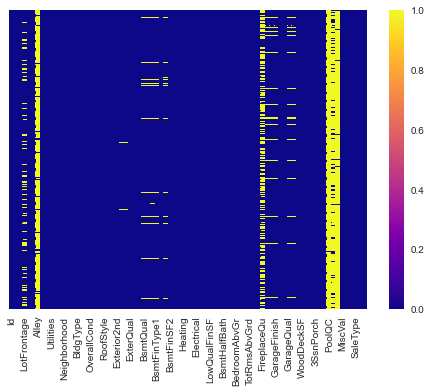

In [369]:
sns.heatmap(train.isnull(),yticklabels=False, cmap='plasma')

In [370]:
train.isnull().sum().sort_values(ascending=False)[0:19]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [371]:
test.isnull().sum().sort_values(ascending=False)[0:33]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

### Drop columns with too much missing values
Plus there is so much features to analyse that it may be better to concentrate on the ones which can give us real insights. Also I tried including these features in model but score was not up do the mark

In [372]:
columns = ['Alley', 'MiscFeature', 'Fence', 'GarageYrBlt']

train.drop(columns=columns, inplace=True)
test.drop(columns=columns, inplace=True)
train['PoolQC'] = train['PoolQC'].fillna('None')
test['PoolQC'] = test['PoolQC'].fillna('None')

train.drop(columns=['Id'], inplace=True)

### Use mean for filling null values for numerical features

In [373]:
columns = ['LotFrontage', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', 'GarageArea']

for item in columns:
    train[item] = train[item].fillna(train[item].mean())
    test[item] = test[item].fillna(test[item].mean())

### Use mode for filling null values for categorical features

In [374]:
columns = ['BsmtCond', 'BsmtQual', 'FireplaceQu', 'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual', 'MSZoning',
           'MasVnrType', 'MasVnrArea', 'BsmtExposure','BsmtFinType2', 'BsmtFinType1', 'Electrical',  'Utilities',
           'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual']

for item in columns:
    train[item] = train[item].fillna(train[item].mode()[0])
    test[item] = test[item].fillna(test[item].mode()[0])

### Checking for missing values if any!

In [375]:
train.isnull().any().any()

False

In [376]:
test.isnull().any().any()

False

# Exploratory Data Analysis(EDA)

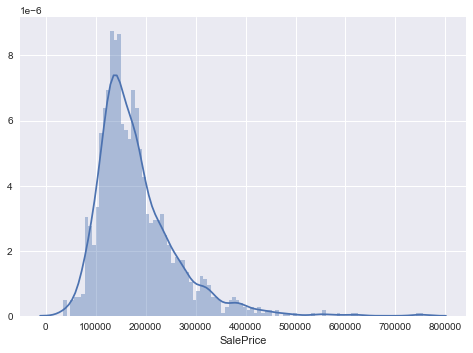

In [377]:
sns.distplot(train['SalePrice'], bins=100);

With this information we can see that the prices are skewed right and some outliers lies above ~500,000. We will eventually want to get rid of the them to get a normal distribution of the independent variable (`SalePrice`) for machine learning.

**Data Frame with only numerical features**

In [378]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


### Take Top strongly correlated values with SalePrice:

**I tried Selecting Top 10 features and trained my model but score was not up to the mark**

In [379]:
df_num_corr = df_num.corr()['SalePrice'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) >= 0].sort_values(ascending=False)
golden_features_list

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Correlation by itself does not always explain the relationship between data so ploting them could even lead us to new insights and in the same manner, check that our correlated values have a linear relationship to the `SalePrice`.

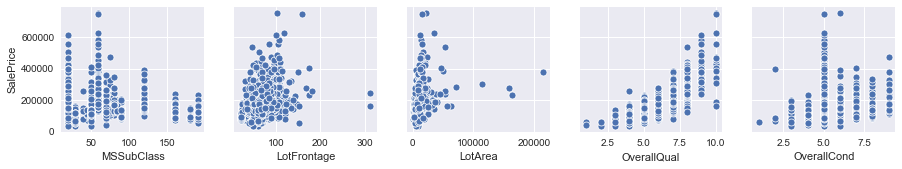

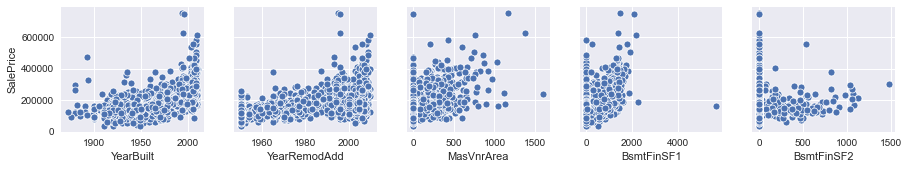

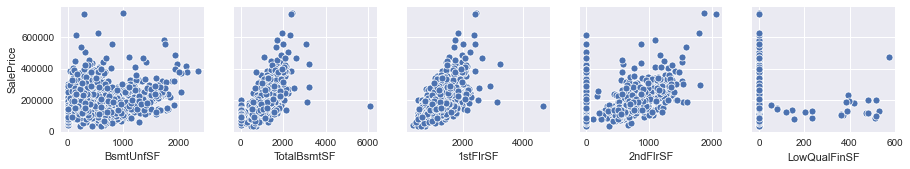

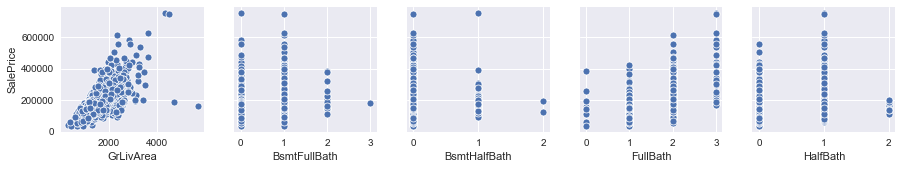

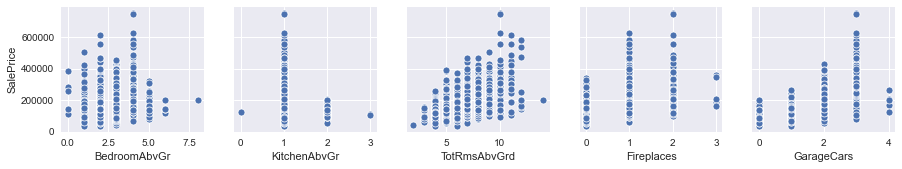

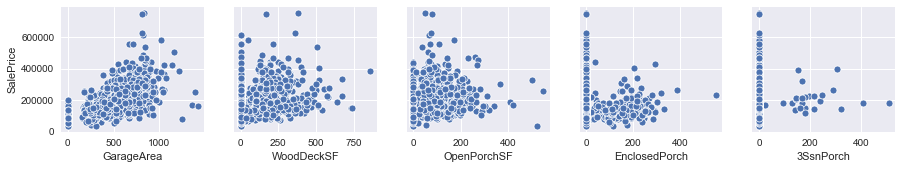

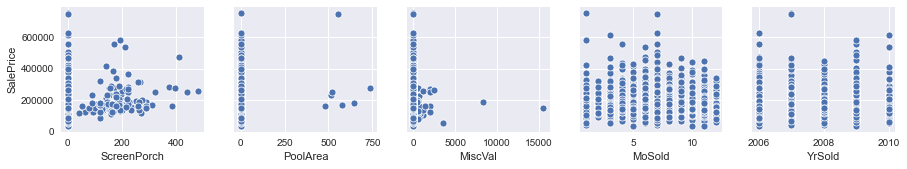

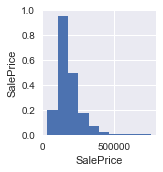

In [380]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['SalePrice'])

if we look closely at the data we can see that a lot of data points are located on `x = 0` which may indicate the absence of such feature in the house.

### Let's examine feature by correlation matrix

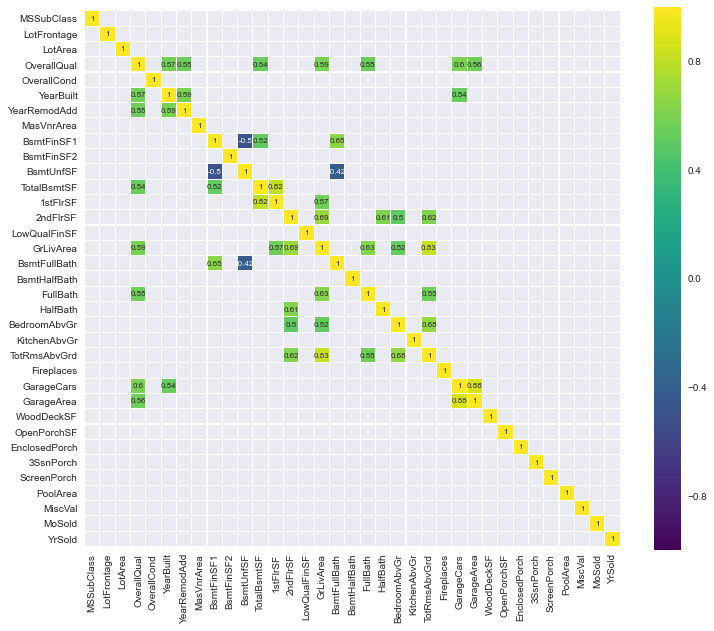

In [381]:
corr = df_num.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Let's examine Non Numerical Features**

In [382]:
df_not_num = train.select_dtypes(include = ['O'])

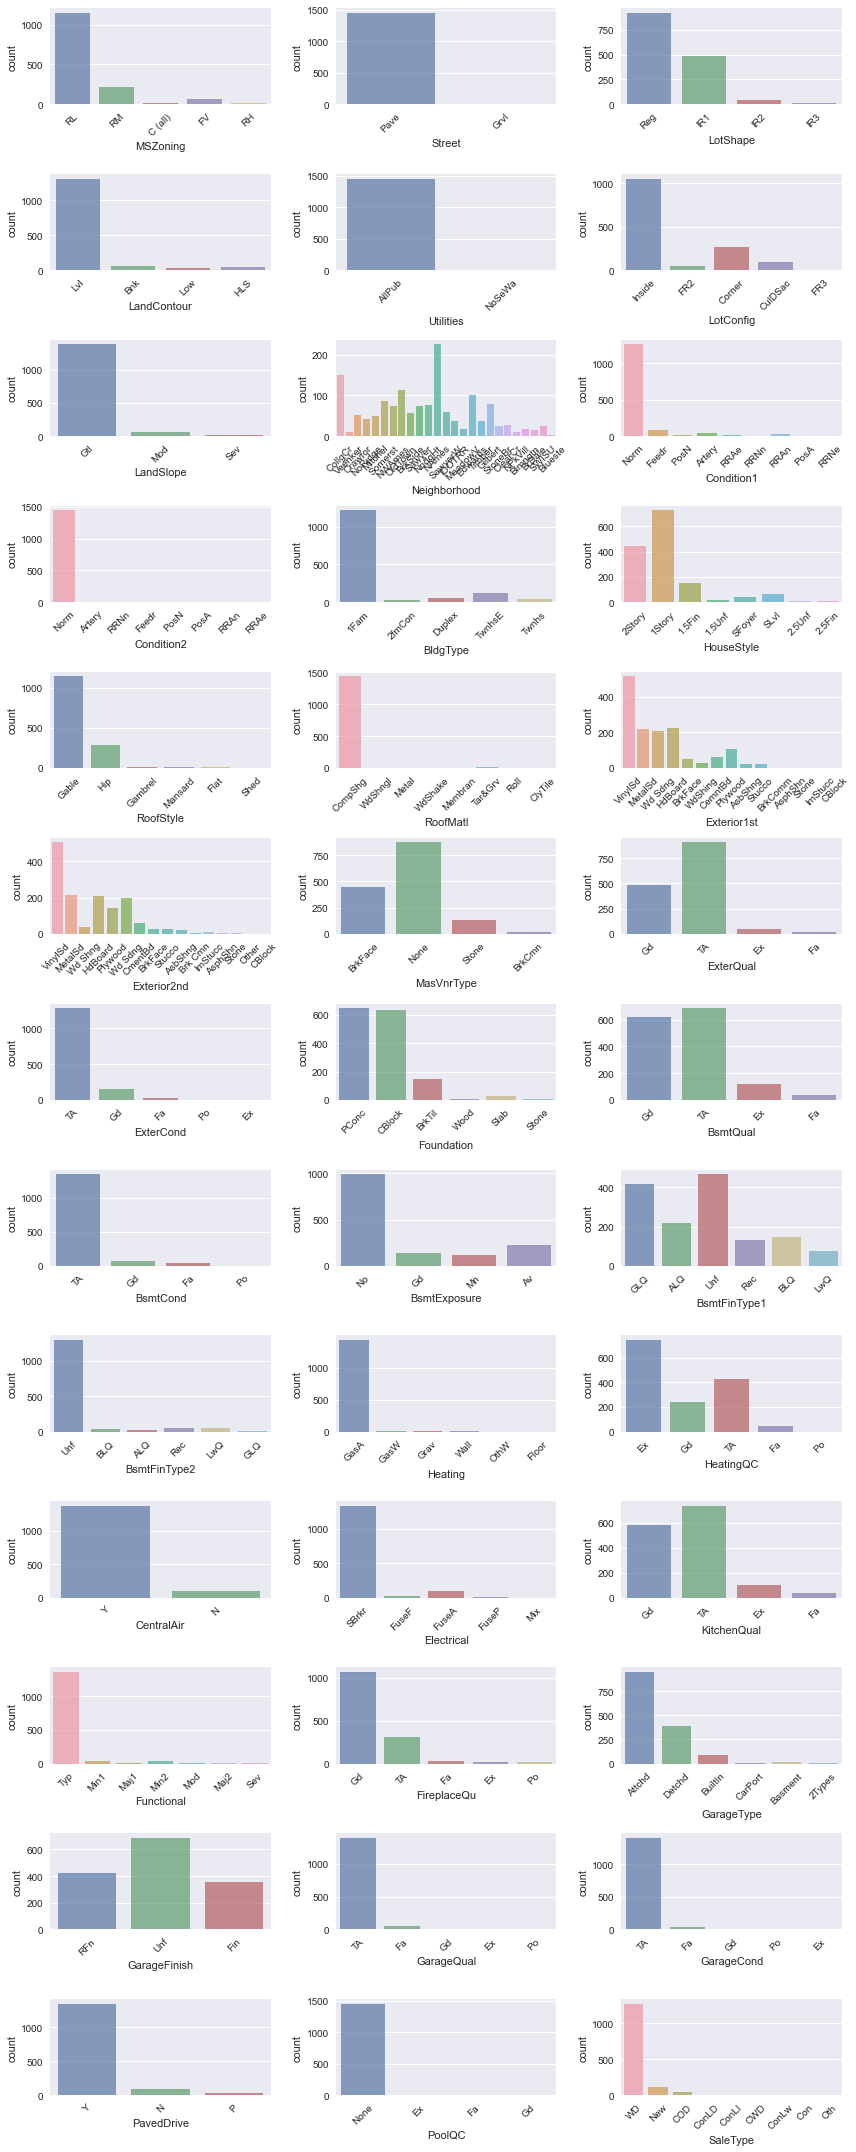

In [383]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

We can see that some categories are predominant for some features such as `Utilities`, `Heating`, `GarageCond`, `Functional`... These features may not be relevant for our predictive model

Let's Just exclude that features from our model

In [384]:
golden_features_list1 = list(df_not_num.columns)

In [385]:
excluded_features = ['GarageCond', 'Functional', 'Heating', 'BsmtFinType2', 'RoofMatl', 'Street', 'Utilities']

for item in excluded_features:
    golden_features_list1.remove(item)

# Feature selection

In [386]:
golden_features_list = list(golden_features_list.index)

In [387]:
golden_features_list.extend(golden_features_list1)

In [388]:
train = train[golden_features_list]

In [389]:
test = test[golden_features_list]

# Feature Engineering

We will be using onehot encoding technique for feature engineering 

In [390]:
final_df = pd.concat([train, test], axis=0)

In [391]:
final_df.shape

(2919, 68)

**Ensuring null values is any**

In [392]:
final_df.isnull().any().any()

False

In [393]:
def One_hot_encoding(columns):
    df_final=final_df
    i=0
    for fields in columns:
        df1=pd.get_dummies(final_df[fields],drop_first=True)
        
        final_df.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:           
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
       
        
    df_final=pd.concat([final_df,df_final],axis=1)
        
    return df_final

In [394]:
df_final = One_hot_encoding(golden_features_list1)

In [395]:
df_final.shape

(2919, 209)

In [396]:
df_final = df_final.loc[:,~df_final.columns.duplicated()]

In [397]:
df_final.shape

(2919, 157)

In [398]:
df_Train=df_final.iloc[:1460,:]
df_Test=df_final.iloc[1460:,:]

In [415]:
my_temp = pd.concat([df_Train,y],axis=1)
#my_temp.to_csv('train_conv_1.csv',index=False)
#df_Test.to_csv('test_conv_1.csv',index=False)

# Train Xgboost Classifier

In [399]:
import xgboost

In [400]:
regressor = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=900, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [401]:
regressor.fit(df_Train,y);

In [402]:
y_pred = regressor.predict(df_Test)

In [403]:
y_pred

array([118209.48 , 163561.56 , 185090.92 , ..., 172092.58 , 113204.484,
       231117.92 ], dtype=float32)

In [404]:
pred=pd.DataFrame(y_pred)
samp = pd.read_csv('test.csv')
sub = pd.concat([samp['Id'],pred], axis=1)
sub.columns=['Id','SalePrice']

In [405]:
sub

,Id,SalePrice
0,1461,118209.476562
1,1462,163561.562500
2,1463,185090.921875
3,1464,193633.093750
4,1465,194834.796875
...,...,...
1454,2915,86359.578125
1455,2916,65470.312500
1456,2917,172092.578125
1457,2918,113204.484375


In [407]:
#sub.to_csv('My_sub3.csv',index=False)